# Import

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer

In [3]:
df = pd.read_csv('winemag-data-130k-v2.csv')

In [4]:
df.drop(columns='Unnamed: 0', inplace=True)

In [5]:
df.head(1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


# Percentual de nulos

In [6]:
pd.DataFrame(df.isnull().sum(axis=0)).sort_values(by=0, ascending=False)/df.shape[0]

,0
region_2,0.611367
designation,0.288257
taster_twitter_handle,0.240154
taster_name,0.201922
region_1,0.163475
price,0.069215
country,0.000485
province,0.000485
variety,0.000008
description,0.000000


Resposta: 2 colunas com percentual de nulos acima de 25%

# Discretização da variável points

In [7]:
df.dropna(subset=['points'], inplace=True)

In [8]:
from sklearn.preprocessing import KBinsDiscretizer

train = df.points.dropna().values.reshape(-1,1)

discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')

discretizer.fit(train)

df['points_group'] = discretizer.transform(train)*5 + 80

In [9]:
df.points_group.value_counts()

85.0    68496
90.0    46629
80.0    12430
95.0     2416
Name: points_group, dtype: int64

# df_price_per_group

In [10]:
df_price_per_group = df[["country", "points_group","price"]].groupby(["country", "points_group"]).mean()
df_price_per_group

price
country   points_group           
Argentina 80.0          14.421735
          85.0          19.427708
          90.0          50.348745
          95.0          83.363636
Armenia   85.0          14.500000
...                           ...
Ukraine   80.0           9.300000
          85.0           9.000000
Uruguay   80.0          19.625000
          85.0          25.205882
          90.0          40.764706

[120 rows x 1 columns]

In [11]:
df = df.merge(df_price_per_group, on=["country", "points_group"], suffixes=('','_per_group'))
df.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,points_group,price_per_group
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,85.0,28.757327
1,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,85.0,28.757327
2,Italy,This is dominated by oak and oak-driven aromas...,Rosso,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Masseria Setteporte 2012 Rosso (Etna),Nerello Mascalese,Masseria Setteporte,85.0,28.757327


In [12]:
df.price.fillna(df.price_per_group, inplace=True)

In [13]:
round(df.price.mean(),2)

35.61

# Outliers de price

In [14]:
df = pd.read_csv('winemag-data-130k-v2.csv')

In [15]:
df.dropna(subset=['price'], inplace=True)

In [16]:
z = np.abs(stats.zscore(df.price))
df['z-scores'] = z

In [17]:
df[z>3].shape

(1177, 15)

1177 é a resposta

# Princípio de Pareto na variavel country

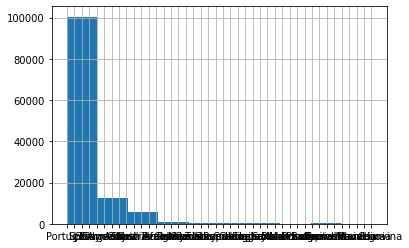

In [18]:
df.country.hist()

In [19]:
country_counts = df['country'].value_counts().to_frame('Count').rename_axis('Country').reset_index()

In [20]:
country_counts['freq%'] = country_counts["Count"]/country_counts["Count"].sum() * 100
country_counts['cumulative_sum%'] = country_counts['freq%'].cumsum()/country_counts['freq%'].sum() * 100

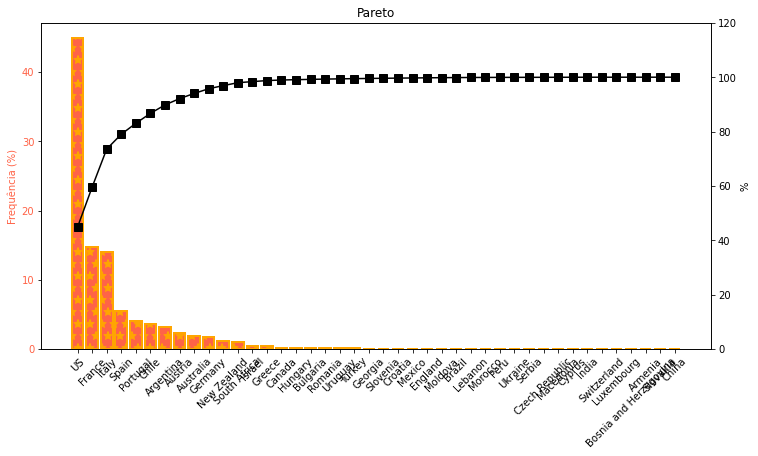

In [21]:
fig,ax1 = plt.subplots(figsize = (12,6))

ax1.set_title('Pareto')

color1 = 'tomato'
ax1.set_ylabel('Frequência (%)',color = color1)

ax1.bar(country_counts['Country'], country_counts['freq%'],color = color1,edgecolor = 'orange',linewidth = 2,\
       hatch = '*')
ax1.tick_params(axis = 'y',labelcolor = color1)

color2 = 'black'
ax2 = ax1.twinx() # compartilhar o mesmo eixo x
ax2.set_ylabel('%',color = color2) 

ax2.plot(country_counts['Country'], country_counts['cumulative_sum%'],color = color2,marker = 's',markersize = 8, linestyle = '-')

ax2.tick_params(axis = 'y',labelcolor = color2)
ax2.set_ylim([0,120])

for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
    
plt.savefig('GraficoPareto.png',format='png',dpi = 600, bbox_inches = 'tight')
plt.show()

In [22]:
country_counts.head(7)

,Country,Count,freq%,cumulative_sum%
0,US,54265,44.878263,44.878263
1,France,17776,14.701115,59.579377
2,Italy,16914,13.988223,73.567601
3,Spain,6573,5.436005,79.003606
4,Portugal,4875,4.031725,83.035330
5,Chile,4416,3.652122,86.687452
6,Argentina,3756,3.106289,89.793741


Resp: Esses países ai com soma acumulativa de aproximadamente 90%

# US Filtro e One Hot Encoding em itens de province com contagem > 100

In [23]:
df = pd.read_csv('winemag-data-130k-v2.csv')
df.drop(columns='Unnamed: 0', inplace=True)
dfb = df[df['country'] == 'US'].copy()


In [24]:
dfb.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [25]:
dfc = dfb[dfb.groupby("province")['province'].transform('size') > 100]

In [26]:
pd.get_dummies(dfc['province'], prefix='province', drop_first=True)

,province_Idaho,province_Michigan,province_New York,province_Oregon,province_Virginia,province_Washington
2,0,0,0,1,0,0
3,0,1,0,0,0,0
4,0,0,0,1,0,0
10,0,0,0,0,0,0
12,0,0,0,0,0,0
...,...,...,...,...,...,...
129945,0,0,0,0,0,0
129949,0,0,0,0,0,0
129950,0,0,0,0,0,0
129952,0,0,0,0,0,0


Resposta: 6 novas categorias

# Transformação Box-Cox e lambda

In [27]:
boxcox_tf = PowerTransformer(method='box-cox', standardize=False)

cols = ['price']

for col in cols:
  df['{}_box_cox'.format(col)] = boxcox_tf.fit_transform(df[cols])

In [28]:
round(boxcox_tf.lambdas_[0],3)

-0.296

# Tratamento de texto da coluna Description (NLP)

In [29]:
from nltk.tokenize import word_tokenize, TreebankWordTokenizer, WordPunctTokenizer, WhitespaceTokenizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import string
import re 

In [30]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
def clean_text(sentence):
  word_tokens = word_tokenize(sentence)
  new_words = [word for word in word_tokens if (word not in string.punctuation \
                                                and not re.match("[0-9]+",word))]
  clean_tokens = new_words[:]
  for token in clean_tokens:
    if token in stopwords.words('english'):
      clean_tokens.remove(token)
  return ' '.join(clean_tokens)

In [32]:
df['description_treat'] = df.description.apply(clean_text)
df.head(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,price_box_cox,description_treat
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,NaN,Aromas include tropical fruit broom brimstone ...
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,1.862305,This ripe fruity wine is smooth still structur...
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,1.831054,Tart snappy flavors lime flesh rind dominate S...
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,1.796766,Pineapple rind lemon pith orange blossom start...
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2.395577,Much like regular bottling this comes across r...


Apesar de ter importado um stemizador, ele não foi utilizado, assim, o que ocorre realmente na função é a remoção de números, vírgulas e artigos

# Preço médio por provincia - Preço unitário

In [33]:
df = pd.read_csv('winemag-data-130k-v2.csv')
df.drop(columns='Unnamed: 0', inplace=True)

In [34]:
dfb = df[['province', 'price']].groupby(by='province').mean().reset_index()
dfb.shape

(425, 2)

In [35]:
dfb.head()

,province,price
0,Achaia,23.000000
1,Aconcagua Costa,23.074074
2,Aconcagua Valley,40.298246
3,Aegean,33.409091
4,Agioritikos,24.000000


In [36]:
df = df.merge(dfb, on=["province"], suffixes=('','_province_mean'))
df.dropna(subset=['price'], inplace=True)

In [37]:
df.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
price_province_mean      float64
dtype: object

In [40]:
df['price_delta'] = df['price'] - df['price_province_mean']
df.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,price_province_mean,price_delta
1,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,27.623477,-11.623477
3,Italy,Delicate aromas recall white flower and citrus...,Ficiligno,87,19.0,Sicily & Sardinia,Sicilia,NaN,Kerin O’Keefe,@kerinokeefe,Baglio di Pianetto 2007 Ficiligno White (Sicilia),White Blend,Baglio di Pianetto,27.623477,-8.623477
4,Italy,"Aromas of prune, blackcurrant, toast and oak c...",Aynat,87,35.0,Sicily & Sardinia,Sicilia,NaN,Kerin O’Keefe,@kerinokeefe,Canicattì 2009 Aynat Nero d'Avola (Sicilia),Nero d'Avola,Canicattì,27.623477,7.376523
